In [32]:
# pip install imbalanced-learn

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
# check version number
import imblearn
print(imblearn.__version__)

0.7.0


In [35]:
from sklearn.datasets import make_classification
from collections import Counter

# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [36]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


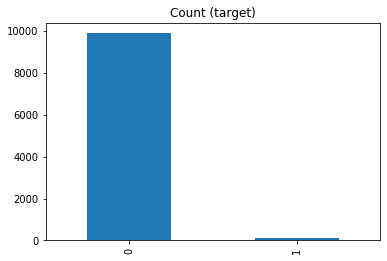

In [37]:
df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

In [38]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

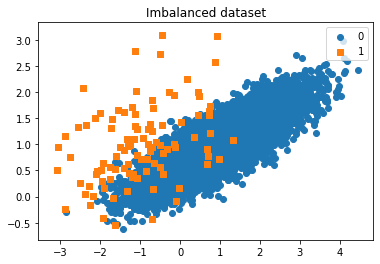

In [39]:
plot_2d_space(X, y, 'Imbalanced dataset')

Confusion matrix:
 [[9900    0]
 [   0  100]]


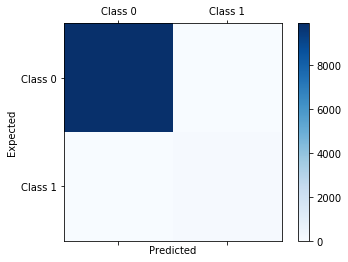

In [40]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=y, y_pred=y)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [41]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X, y) # doctest : +ELLIPSIS

LinearSVC()

In [44]:
from sklearn import  metrics

print("f1_score                full  ", metrics.f1_score(y, clf.predict(X)) )
print("Balanced_accuracy_score full  ", metrics.balanced_accuracy_score(y, clf.predict(X)) )

f1_score                full   0.6068965517241379
Balanced_accuracy_score full   0.719949494949495


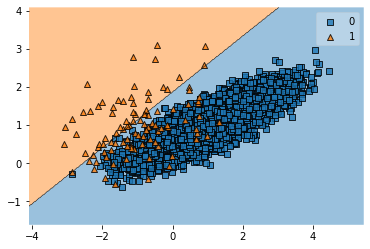

In [45]:
# from help_plot import plot_decision_regions
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X, y, clf)
plt.show()

Confusion matrix:
 [[9899    1]
 [  56   44]]


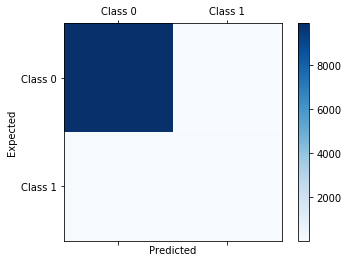

In [46]:
conf_mat = confusion_matrix(y_true=y, y_pred=clf.predict(X))
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Naive random over-sampling

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class

In [47]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 9900), (1, 9900)]


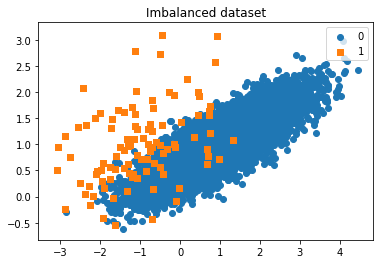

In [48]:
plot_2d_space(X_resampled, y_resampled, 'Imbalanced dataset')

In [49]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_resampled, y_resampled) # doctest : +ELLIPSIS

LinearSVC()

In [50]:
from sklearn import  metrics
print("F1 on full data       ", metrics.f1_score(y, clf.predict(X)))
print("F1 on resamble data  ", metrics.f1_score(y_resampled, clf.predict(X_resampled)))


print("Balanced_accuracy_score full  ", metrics.balanced_accuracy_score(y, clf.predict(X)) )
print("Balanced_accuracy_score       ", metrics.balanced_accuracy_score(y_resampled, clf.predict(X_resampled)) )

F1 on full data        0.17688442211055275
F1 on resamble data   0.8971519802235154
Balanced_accuracy_score full   0.8992424242424242
Balanced_accuracy_score        0.8991414141414141


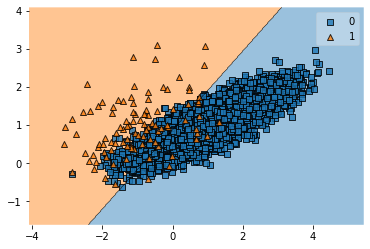

In [51]:
# from help_plot import plot_decision_regions
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X, y, clf)
plt.show()

Confusion matrix:
 [[9093  807]
 [  12   88]]


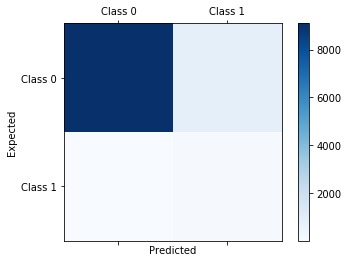

In [52]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y, y_pred=clf.predict(X))
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# over-sample minority classes SMOTE


SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

<img src="Grafika/smote.png" width="550">

We'll use 
puthon```
ratio='minority'
```
to resample the minority class.



SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

… SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

— Page 47, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013. 

(https://www.amazon.com/dp/1118074629/ref=as_li_ss_tl?&linkCode=sl1&tag=inspiredalgor-20&linkId=615e87a9105582e292ad2b7e2c7ea339&language=en_US)

This procedure can be used to create as many synthetic examples for the minority class as are required. As described in the paper, it suggests first using random undersampling to trim the number of examples in the majority class, then use SMOTE to oversample the minority class to balance the class distribution.

In [53]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 9900), (1, 9900)]


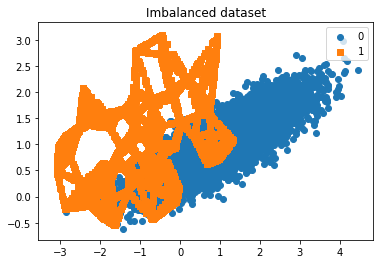

In [54]:
plot_2d_space(X_resampled, y_resampled, 'Imbalanced dataset')

In [55]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_resampled, y_resampled) # doctest : +ELLIPSIS

LinearSVC()

In [57]:
from sklearn import  metrics
print("F1 on full data       ", metrics.f1_score(y, clf.predict(X)))
print("F1 on fresamble data  ", metrics.f1_score(y_resampled, clf.predict(X_resampled)))

print("Balanced_accuracy_score full  ", metrics.balanced_accuracy_score(y, clf.predict(X)) )
print("Balanced_accuracy_score       ", metrics.balanced_accuracy_score(y_resampled, clf.predict(X_resampled)) )

F1 on full data        0.19577308120133483
F1 on fresamble data   0.9110221674876847
Balanced_accuracy_score full   0.9040909090909091
Balanced_accuracy_score        0.9124242424242424


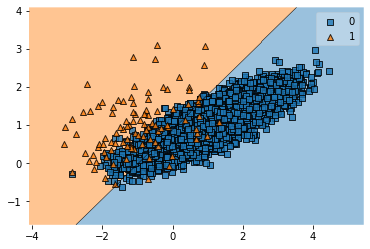

In [58]:
# from help_plot import plot_decision_regions
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X, y, clf)
plt.show()

Confusion matrix:
 [[9189  711]
 [  12   88]]


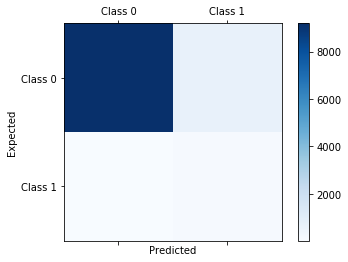

In [60]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y, y_pred=clf.predict(X))
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# over-sample minority classes ADASYN

Another approach involves generating synthetic samples inversely proportional to the density of the examples in the minority class.

That is, generate more synthetic examples in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.

In [61]:
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 9900), (1, 9899)]


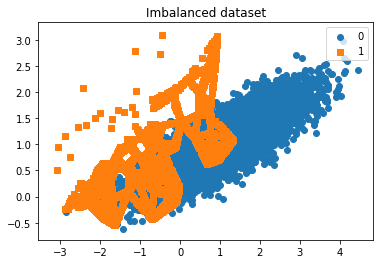

In [62]:
plot_2d_space(X_resampled, y_resampled, 'Imbalanced dataset')

In [63]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_resampled, y_resampled) # doctest : +ELLIPSIS

LinearSVC()

In [66]:
from sklearn import  metrics
print("F1 on full data       ", metrics.f1_score(y, clf.predict(X)))
print("F1 on resamble data  ", metrics.f1_score(y_resampled, clf.predict(X_resampled)))

print("Balanced_accuracy_score full  ", metrics.balanced_accuracy_score(y, clf.predict(X)) )
print("Balanced_accuracy_score       ", metrics.balanced_accuracy_score(y_resampled, clf.predict(X_resampled)) )

F1 on full data        0.11353711790393012
F1 on resamble data   0.8369749627268521
Balanced_accuracy_score full   0.8836868686868686
Balanced_accuracy_score        0.8398395103678465


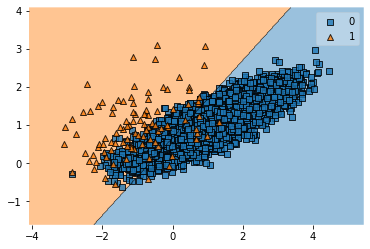

In [144]:
# from help_plot import plot_decision_regions
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X, y, clf)
plt.show()

Confusion matrix:
 [[8488 1412]
 [   9   91]]


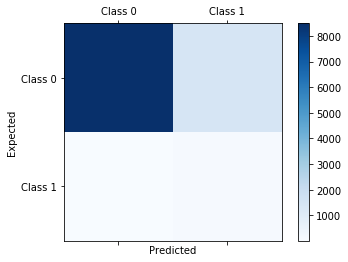

In [67]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y, y_pred=clf.predict(X))
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Pipeline

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5)

pipe = Pipeline([('preprocessing', StandardScaler()), ('over', SMOTE()), ('classifier', LinearSVC())])

param_grid = {
            'preprocessing': [StandardScaler(), None]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(X, y)
grid_1.best_params_

{'preprocessing': StandardScaler()}

In [69]:
print("Balanced_accuracy_score  ", metrics.balanced_accuracy_score(y, grid_1.best_estimator_.predict(X)) )

Balanced_accuracy_score   0.8990909090909092


In [156]:
# https://imbalanced-learn.org/stable/generated/imblearn.metrics.classification_report_imbalanced.html#imblearn.metrics.classification_report_imbalanced

# https://imbalanced-learn.org/stable/auto_examples/evaluation/plot_metrics.html#sphx-glr-auto-examples-evaluation-plot-metrics-py

# Show the classification report
print(classification_report_imbalanced( y, grid_1.best_estimator_.predict(X) ))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.51      0.87      0.91      0.64      0.89      0.79       500
          1       0.98      0.91      0.87      0.94      0.89      0.79      4500

avg / total       0.94      0.90      0.88      0.91      0.89      0.79      5000

